# Domain Decomposition and Grid Generation on the Cubed-Sphere

This notebooks demonstrates how to generate a cubed-sphere grid. To this end, we need to setup an MPI-environment, partition the cube into computational subdomains, and compute the necessary metric terms for projecting the cube onto the sphere. We use a 6x1x1 layout with 6 MPI ranks, but this can be modified as needed.

In addition, this notebook also demonstrates how to visualize fields (e.g. lat/lon, metric terms).

## Configuration

First, we need to define some parameters which are needed for setting up a parallel environment and a cubed-sphere grid.

In [1]:
# Number of tiles on the cube
ntiles = 6

# Size of each cubed-sphere tile
nx = 20
ny = 20
nz = 79

# Nubmer of halo-points
nhalo = 3

# Number of MPI-ranks along x- and y-direction on each tile
# Note: Must be equal for the time being
layout = (1, 1)
assert layout[0] == layout[1]

# GT4Py backend to use for storages
backend = "numpy"

## Setup MPI-environment

We need to launch an MPI-cluster of Python workers which has the correct number of MPI-ranks and then connect to it. The `%autopx` command will make sure that the code in all of the cells being executed is executed on the workers. We also need to make sure that the configuration is broadcast to all workers.

Once the cluster is spun up, we can initialize MPI4Py on the workers and get some basic information from the MPI-environment.

*Note: In order to shutdown the MPI-cluster, you need to execute `%autopx` again and then use the `rc.shutdown()` command.*

In [2]:
import ipyparallel as ipp

# spinup cluster of MPI-workers
num_ranks = ntiles * layout[0] * layout[1]
cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "ntiles": ntiles,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "nhalo": nhalo,
        "layout": layout,
        "backend": backend,
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [3]:
#%autopx
#cluster.shutdown()

In [4]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

print(f"I am MPI-rank {mpi_rank} of a total of {mpi_size}")

[stdout:1] I am MPI-rank 1 of a total of 6


[stdout:0] I am MPI-rank 0 of a total of 6


[stdout:2] I am MPI-rank 2 of a total of 6


[stdout:5] I am MPI-rank 5 of a total of 6


[stdout:4] I am MPI-rank 4 of a total of 6


[stdout:3] I am MPI-rank 3 of a total of 6


## Domain decomposition

The `pace.util` package provides a number of convenience functions to facilitate domain-decomposition.

- `TilePartitioner`: determines domain-decomposition on a single tile of the cubed-sphere;
- `CubedSpherePartitioner`: determines domain-decomposition of the entire cubed-sphere, including information about the orientation of each tile
- `CubedSphereCommunicator`: performs communication between subdomains on the partitioned cubed-sphere, including scattering/gathering of fields

In [5]:
from pace.util import (
    CubedSphereCommunicator,
    CubedSpherePartitioner,
    Quantity,
    QuantityFactory,
    SubtileGridSizer,
    TilePartitioner,
)

# create a partitioning of the computational domain on the cube
partitioner = CubedSpherePartitioner(TilePartitioner(layout))

# create an associated communicator to help with
# halo-updates as well as gather/scatter operations
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

[output:3]

[output:4]

[output:0]

[output:2]

[output:5]

[output:1]

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

## Data storages and fields

Furthermore `pace.util` contains helper classes which facilitate the allocation of data storages for fields on the partitiones cubed-sphere grid.

- `SubtileGridSizer`: determines the size of a local array (subtile aka subdomain) for a given MPI-rank
- `Quantity`: Basic data storage for a field with the associated meta-data (location on the grid, units, ...)
- `QuantityFactory`: creates quantities given a `GridSizer` and a GT4Py backend

In [6]:
# useful for easily allocating distributed fields (data storages)

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=nx,
    ny_tile=ny,
    nz=nz,
    n_halo=nhalo,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

# useful for easily allocating distributed data storages (fields)
quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [7]:
# create a field at the cell center
temperature = quantity_factory.zeros(dims=("x", "y"), units="degrees", dtype="float")
if mpi_rank == 0:
    print(f"Size of temperature field on rank 0 is {temperature.extent}")

# create a field staggered in the x-direction
u_velocity = quantity_factory.zeros(
    dims=("x_interface", "y"), units="m/s", dtype="float"
)
if mpi_rank == 0:
    print(f"Size of u-velocity field on rank 0 is {u_velocity.extent}")

[stdout:0] Size of temperature field on rank 0 is (20, 20)
Size of u-velocity field on rank 0 is (21, 20)


## Grid generation and metric terms

Once we have decomposed the computational domain on the cube, we still need to project the cube onto the sphere and compute the associated metric terms that are essential for numerical discretization on the cubed-sphere.

The `pace.util.grid` package implements helper functions which make this very easy:
- `MetricTerms`: class to compute the metric terms of the cubed-sphere grid
- `GridData`: storage of basic grid data (e.g. lat, lon, area, dx, dy, ...)

In [8]:
from pace.util.grid import GridData, MetricTerms

# create the object to compute metric terms
metric_terms = MetricTerms(quantity_factory=quantity_factory, communicator=communicator)

# compute the grid data
grid_data = GridData.new_from_metric_terms(metric_terms)

if mpi_rank == 0:
    print(dir(grid_data))
    print(type(grid_data.lon.data))

[stderr:2] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stdout:0] ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_angle_data', '_contravariant_data', '_horizontal_data', '_vertical_data', 'a11', 'a12', 'a21', 'a22', 'ak', 'area', 'area_64', 'bk', 'cos_sg1', 'cos_sg2', 'cos_sg3', 'cos_sg4', 'cosa', 'cosa_s', 'cosa_u', 'cosa_v', 'dx', 'dxa', 'dxc', 'dy', 'dya', 'dyc', 'edge_e', 'edge_n', 'edge_s', 'edge_w', 'ks', 'lat', 'lat_agrid', 'lon', 'lon_agrid', 'new_from_metric_terms', 'p_ref', 'ptop', 'rarea', 'rarea_c', 'rdx', 'rdxa', 'rdxc', 'rdy', 'rdya', 'rdyc', 'rsin2', 'rsin_u', 'rsin_v', 'rsina', 'sin_sg1', 'sin_sg2', 'sin_sg3', 'sin_sg4', 'sina_u', 'sina_v']
<class 'numpy.ndarray'>


## Gathering distributed fields

To gather distributed fields on the root rank, we need to wrap the metric terms (which are GT4Py data storages) into a Quantity. Then we can use the communicator's gather functionality to gather the field onto the root rank.

In [9]:
import numpy as np
from pace.util import Quantity

# convert the GT4Py storages into Quantity objects
lon = Quantity(
    metric_terms.lon.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units="degrees",
    origin=(nhalo, nhalo),
    extent=(nx + 1, ny + 1),
    gt4py_backend=backend,
)
lat = Quantity(
    metric_terms.lat.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units="degrees",
    origin=(nhalo, nhalo),
    extent=(nx + 1, ny + 1),
    gt4py_backend=backend,
)

# gather the distributed fields into a global field on the root rank
global_lon = communicator.gather(lon)
global_lat = communicator.gather(lat)

print(type(global_lon))

[stdout:5] <class 'NoneType'>


[stdout:3] <class 'NoneType'>


[stdout:2] <class 'NoneType'>


[stdout:1] <class 'NoneType'>


[stdout:4] <class 'NoneType'>


[stdout:0] <class 'pace.util.quantity.Quantity'>


## Plotting the mesh and fields

Plotting is a sequential operation. We thus need to use the gathered field (from above) to plot only on the root rank. Here, we use the `fv3viz` package which facilitates plotting `Quantity` objects on the cubed-sphere grid.

We start off by simply visualizing the computation grid of the cubed-sphere (using the Robinson projection). The `pcolormesh_cube` function has many configuration parameters which can be changed to suit the users needs.

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

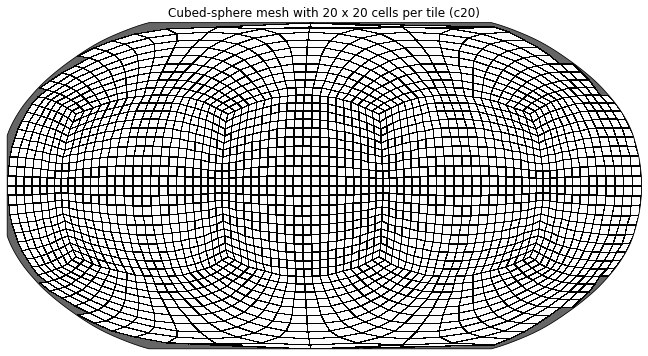

In [10]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

# plot only on root rank
if mpi_rank == 0:
    
    # create empty field
    field = np.zeros(global_lon.data.shape)[:, :-1, :-1]

    # configure figure and plot
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    pcolormesh_cube(
        global_lat.data,
        global_lon.data,
        field,
        cmap="bwr",
        vmin=-1,
        vmax=1,
        edgecolor="k",
        linewidth=0.1,
    )

    ax.set_title(f"Cubed-sphere mesh with {nx} x {ny} cells per tile (c{nx})")

    plt.show()

Similarly, we can plot fields on the cubed-sphere grid using the `pcolormesh_cube` function. We need to make sure we gather distributed fields onto the root rank before plotting.

For example, we can plot the area of each grid cell using the Plate carrée projection.

[output:0]

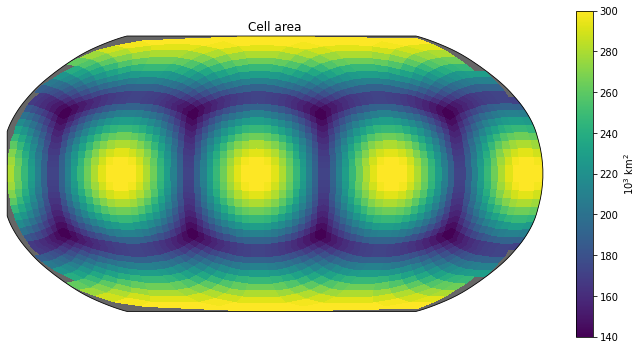

In [11]:
# convert GT4Py storage into Quantity
area = Quantity(
    grid_data.area.data,
    dims=("x", "y"),
    units="m2",
    origin=(nhalo, nhalo),
    extent=(nx, ny),
    gt4py_backend=backend,
)

# rescale to 10^3 km2
area.data[:] = area.data / 1.0e9

# gather data onto root rank
global_area = communicator.gather(area)

# # plot on root rank
if mpi_rank == 0:

    # configure figure and plot
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot data
    f1 = pcolormesh_cube(
        global_lat.data,
        global_lon.data,
        global_area.data,
        cmap="viridis",
        vmin=140,
        vmax=300,
    )

    plt.colorbar(f1, label="$10^3$ km$^2$")

    ax.set_title("Cell area")

    plt.show()

## Recreating this with functions.py

You can reproduce the above steps in a more succinct manner by using the following syntax:

[stderr:5] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:2] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[output:0]

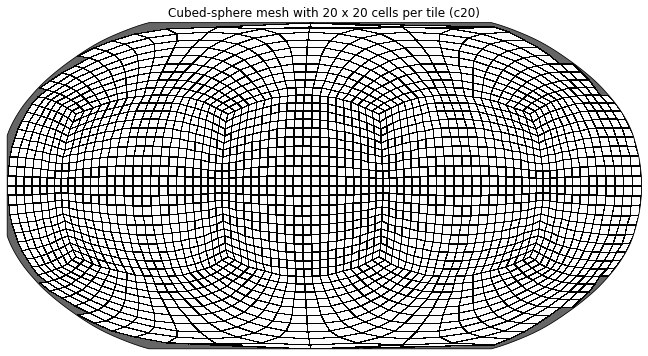

[output:0]

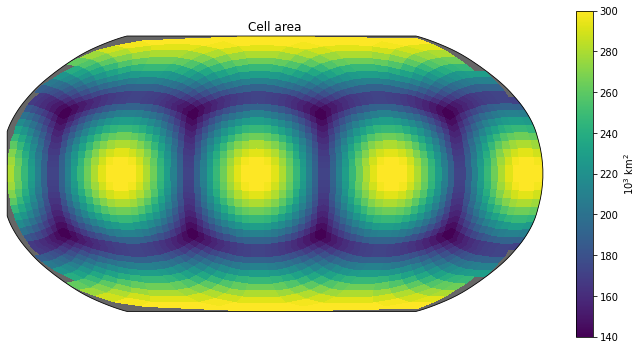

In [12]:
import functions as func

# # a little bit of prep
namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)

# # domain decomposition, grid generation, stencil tools
domain_configuration = func.configure_domain(mpi_comm, dimensions)


global_lon, global_lat = func.get_lon_lat_edges(domain_configuration, dimensions, gather=True)
# # plot grid
if mpi_rank == 0:
    func.plot_grid(global_lon, global_lat, dimensions, fOut="grid_map.png", show=True)

    # # plot area field
    plot_dict = {
        "vmin": 140,
        "vmax": 300,
        "cmap": "viridis",
        "units": "$10^3$ km$^2$",
        "title": "Cell area",
    }

    func.plot_projection_field(
        global_lon, 
        global_lat,
        global_area,
        plot_dict,
        "grid_area.png",
        show=True,
    )